# 4. Project 3 final - Unsupervised Learning

Project 3: Unsupervised Learning
- Enrique Almazán Sánchez
- Judith Briz Galera

## Imports

In [1]:
import time

import pandas as pd
import numpy as np
from scipy import stats

import utils as u

# Visualizing
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

# Feature Selection
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

# Preprocessing
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
from sklearn.preprocessing import (
    LabelEncoder,
    MinMaxScaler, 
    StandardScaler, 
    RobustScaler
)

# Figures of merit
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    auc, 
    roc_auc_score, 
    roc_curve, 
    confusion_matrix, 
    classification_report, 
    r2_score, 
    mean_absolute_error, 
    mean_squared_error
)


# Cross-validation
from sklearn.model_selection import (
    GridSearchCV,
    cross_val_score,
    cross_validate,
    StratifiedKFold,
    RepeatedKFold,
    KFold
)

from sklearn.model_selection import cross_val_score, KFold

from src.utils import plot_scatter, plot_silhouette
from sklearn.cluster import KMeans
import warnings
from sklearn.decomposition import PCA

from sklearn.cluster import AgglomerativeClustering

from sklearn.manifold import TSNE

from sklearn.datasets import make_blobs
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, silhouette_samples
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist
from sklearn.metrics import calinski_harabasz_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import warnings

# Desactivar todas las advertencias (no se recomienda a menos que sea necesario)
warnings.filterwarnings("ignore")

## 1. Dataset import

First of all, we import the clean dataset we obtained in Project 1, which was already split in train and test, but without normalizing it.

In [3]:
# Import train set
train = pd.read_csv('train_data_bcl.csv')
# Import test set
test = pd.read_csv('test_data_bcl.csv')

Now divide each of the sets in features and target variable.

In [4]:
# Divide train set in features and target variable
X_train_prime, y_train_prime = (train.drop('Status', axis=1), train['Status'])
# Divide test set in features and target variable
X_test_prime, y_test_prime = (test.drop('Status', axis=1), test['Status'])

## 2. Feature Selection

First of all, the column 'Patient Identifier' is eliminated, as it does not give any valuable information.

In [5]:
# For train
patient_id_train = X_train_prime['Patient Identifier']
patient_id_train.columns = 'Patient Identifier'
X_train_prime = X_train_prime.drop('Patient Identifier', axis=1)
# For test
patient_id_test = X_test_prime['Patient Identifier']
patient_id_test.columns = 'Patient Identifier'
X_test_prime = X_test_prime.drop('Patient Identifier', axis=1)

Now, different methods of feature selection are performed, in order to take the one that gives better performance.

### 2.1. Correlation between features and their importance regarding the estimation of the target variable.

First, we compute the importance of each feature.

In [6]:
# Create and fit the classifier
clf = ExtraTreesClassifier(n_estimators=50, random_state=10)
clf = clf.fit(X_train_prime, y_train_prime)

# Create and fit SelectFromModel with feature names
model = SelectFromModel(clf, prefit=True)
X_new = model.transform(X_train_prime)

# Get feature importances for all features
importances = dict(zip(X_train_prime.columns, clf.feature_importances_))

And we show the results.

In [7]:
# Find the maximum width of the keys for formatting
max_key_width = max(map(len, importances.keys()))

for key, value in importances.items():
    print(f"{key.ljust(max_key_width)}  {round(value, 3)}")

Jitter in %                                                                 0.036
Absolute Jitter in microseconds                                             0.033
Jitter as relative amplitude perturbation                                   0.045
Jitter as 5-point period perturbation                                       0.041
Absolute Jitter difference between Jitter Cycles                            0.048
Shimmer in %                                                                0.033
Absolute Shimmer in decibels (dB)                                           0.035
Shimmer as 3 point amplitude perturbation                                   0.033
Shimmer as 5 point amplitude perturbation                                   0.038
Shimmer as 11 point amplitude perturbation                                  0.047
Shimmer as Average absolute difference between amplitude of shimmer cycles  0.032
Autocorrelation between NHR and HNR                                         0.038
Noise to Harmoni

Thus, we show the different groups of features which have high correletion between them.

In [9]:
# Creamos una lista con las columnas/características
columns = list(X_train_prime.columns)

# Creamos un diccionario para almacenar los grupos de columnas altamente correlacionadas
correlation_groups = {}

# Iteramos sobre las columnas de la lista creada previamente
for column in columns:
    
    # Flag para indicar si la columna está asignada a un grupo existente
    assigned_to_group = False
    
    # Iteramos sobre los grupos existentes
    for group, group_columns in correlation_groups.items():
        
        # Calculamos la correlación promedio entre la columna actual y las columnas del grupo
        avg_correlation = sum(X_train_prime[column].corr(X_train_prime[col]) for col in group_columns) / len(group_columns)
        
        # Si la correlación promedio es mayor que un umbral, asignamos la columna al grupo
        if avg_correlation > 0.8 or avg_correlation < -0.75:
            correlation_groups[group].append(column)
            assigned_to_group = True
            break
    
    # Si la columna no se asigna a un grupo existente, creamos un nuevo grupo
    if not assigned_to_group:
        correlation_groups[column] = [column]

In [10]:
# Showing the resulting groups
for i, (group, group_columns) in enumerate(correlation_groups.items()):
    print(f"\n{i+1} Group {group}: {group_columns}")


1 Group Jitter in %: ['Jitter in %', 'Absolute Jitter in microseconds', 'Jitter as relative amplitude perturbation', 'Jitter as 5-point period perturbation', 'Absolute Jitter difference between Jitter Cycles']

2 Group Shimmer in %: ['Shimmer in %', 'Absolute Shimmer in decibels (dB)', 'Shimmer as 3 point amplitude perturbation', 'Shimmer as 5 point amplitude perturbation', 'Shimmer as Average absolute difference between amplitude of shimmer cycles']

3 Group Shimmer as 11 point amplitude perturbation: ['Shimmer as 11 point amplitude perturbation']

4 Group Autocorrelation between NHR and HNR: ['Autocorrelation between NHR and HNR', 'Noise to Harmonic Ratio (NHR)']

5 Group Harmonic to Noise Ratio (HNR): ['Harmonic to Noise Ratio (HNR)']

6 Group Median Pitch: ['Median Pitch', 'Mean Pitch', 'Minimum Pitch', 'Mean Period']

7 Group Standard Deviation of Pitch: ['Standard Deviation of Pitch']

8 Group Maximum Pitch: ['Maximum Pitch']

9 Group Number of Pulses: ['Number of Pulses', 'Numb

Now we select one feature per correlation group, which is the one with more importance per group.

In [11]:
# Create a list to add the best features
best_features = []

# Iterating over the correlation_groups as a dictionary of groups of correlated features
# (the created in the previous example)
for group, group_columns in correlation_groups.items():
    # Find the feature with the highest importance in the current group
    best_features.append(max(group_columns, key=lambda x: importances[x]))

We show the selected features.

In [12]:
# Show the features selected
for i, feature in enumerate(best_features):
    print(f"Best feature for group {i+1}: {feature}")

Best feature for group 1: Absolute Jitter difference between Jitter Cycles
Best feature for group 2: Shimmer as 5 point amplitude perturbation
Best feature for group 3: Shimmer as 11 point amplitude perturbation
Best feature for group 4: Noise to Harmonic Ratio (NHR)
Best feature for group 5: Harmonic to Noise Ratio (HNR)
Best feature for group 6: Median Pitch
Best feature for group 7: Standard Deviation of Pitch
Best feature for group 8: Maximum Pitch
Best feature for group 9: Number of Pulses
Best feature for group 10: Standard Deviation of Period
Best feature for group 11: Fraction of unvoiced frames
Best feature for group 12: Number of voice breaks
Best feature for group 13: Degree of voice break


In [13]:
X_train_prime[best_features].columns

Index(['Absolute Jitter difference between Jitter Cycles',
       'Shimmer as 5 point amplitude perturbation',
       'Shimmer as 11 point amplitude perturbation',
       'Noise to Harmonic Ratio (NHR)', 'Harmonic to Noise Ratio (HNR)',
       'Median Pitch', 'Standard Deviation of Pitch', 'Maximum Pitch',
       'Number of Pulses', 'Standard Deviation of Period',
       'Fraction of unvoiced frames', 'Number of voice breaks',
       'Degree of voice break'],
      dtype='object')

In [14]:
clf = clf.fit(X_train_prime[best_features], y_train_prime)

# Get feature importances for all features
importances = dict(zip(X_train_prime[best_features].columns, clf.feature_importances_))

for key, value in importances.items():
    print(f"{key.ljust(max_key_width)}  {round(value, 3)}")

Absolute Jitter difference between Jitter Cycles                            0.116
Shimmer as 5 point amplitude perturbation                                   0.08
Shimmer as 11 point amplitude perturbation                                  0.088
Noise to Harmonic Ratio (NHR)                                               0.07
Harmonic to Noise Ratio (HNR)                                               0.072
Median Pitch                                                                0.087
Standard Deviation of Pitch                                                 0.087
Maximum Pitch                                                               0.097
Number of Pulses                                                            0.072
Standard Deviation of Period                                                0.072
Fraction of unvoiced frames                                                 0.073
Number of voice breaks                                                      0.041
Degree of voice br

In the case we want a more robust feature selection, we can run the following code to only select the three most important features.

In [15]:
#top = u.top_features(importances, 3)
#print(top)

# 3. UNSUPERVISED LEARNING

We rename as X1 the X train data with the features selected for code comfort. 
X1_norm stores the standrardized data that we will need.

We also create a new variable where we perform a dimensionality reduction on the data as a preprocessing stage for future use.


In [158]:
X1 = X_train_prime[best_features]

scaler = StandardScaler()
X1_normalized = scaler.fit_transform(X1)
X1_norm = pd.DataFrame(X1_normalized, columns=X1.columns)
X1_norm.shape

(832, 13)

In [159]:
# reduce dimensionality
X1_reduced = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(X1)
X1_norm_reduced = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(X1_norm)
X1_norm_reduced.shape

(832, 2)

## K MEANS

In this section we will apply the k-means clustering algorithm. 
Different values of k will be used and compared by means of the silhouette metric in order to obtain the optimal number of clusters.

#### Preprocessing
To apply Kmeans algorithm, we must take into account the importance of data preprocessing. 

K-Means is sensitive to the scale of features, meaning that if features have different scales, those with larger scales may dominate the clustering process. For this reason, we will be using standardized data.

Regarding interpretability and visualization, given the high number of dimensions of our dataset, visualizing and interpreting clusters is more challenging. We will therefore explore the option of dimensionality reduction to create a lower-dimensional representation for better visualization and interpretation.



First of all, we will start by applying the elbow method. This technique is used to find the optimal number of clusters between a given range of values of k. It consists on plotting the sum of squared distances against k. The "elbow" of the plot is considered the point where adding more clusters does not significantly reduce the sum of squared distances.

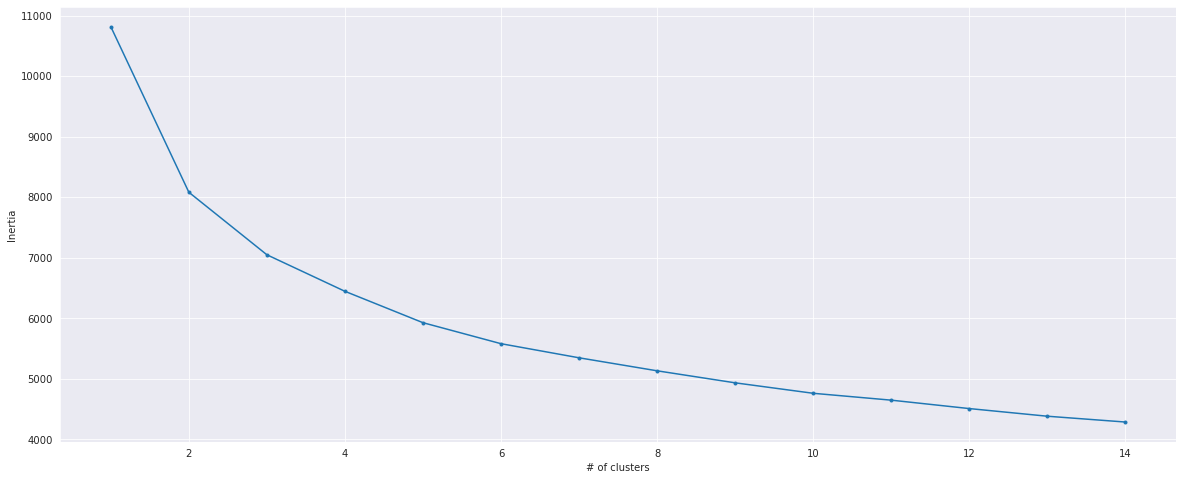

In [152]:
warnings.filterwarnings("ignore")

K = range(1,15)

inertia = []
for k in K:
    kmeans = KMeans(n_clusters=k).fit(X1_norm)
    inertia.append(kmeans.inertia_)
    
plt.plot(K,inertia,'.-')
plt.xlabel('# of clusters')
plt.ylabel('Inertia')
plt.show()

From the observed plot we decided to implement the Kmeans algorithm with 2, 3 and 4 clusters and evaluate the best using silhouette.

We will first perform the evaluation using the normalized data with dimensionality reduction using T-SNE, a powerful visualization approach. T-SNE is robust to outliers due to the use of a heavy-tailed distribution and allows embedding into 2D/3D Spaces for visualization.


For n_clusters = 2, the average silhouette score is: 0.3826447129249573


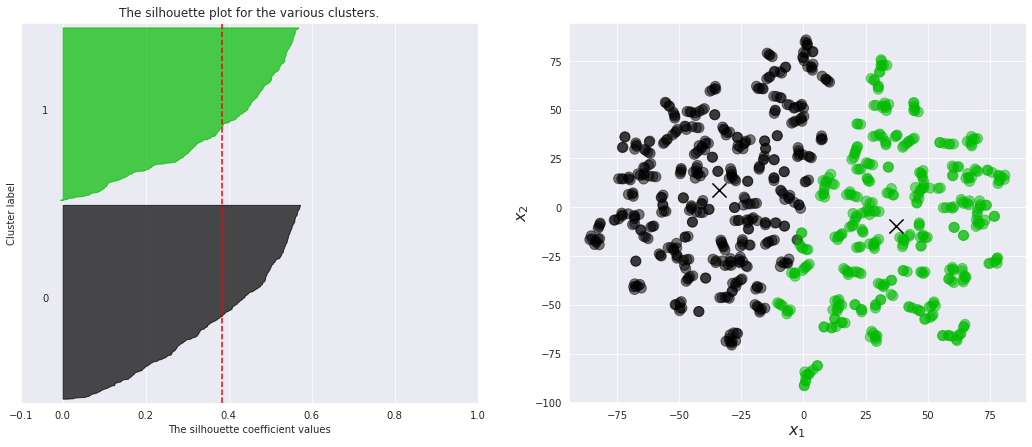

For n_clusters = 3, the average silhouette score is: 0.38180193305015564


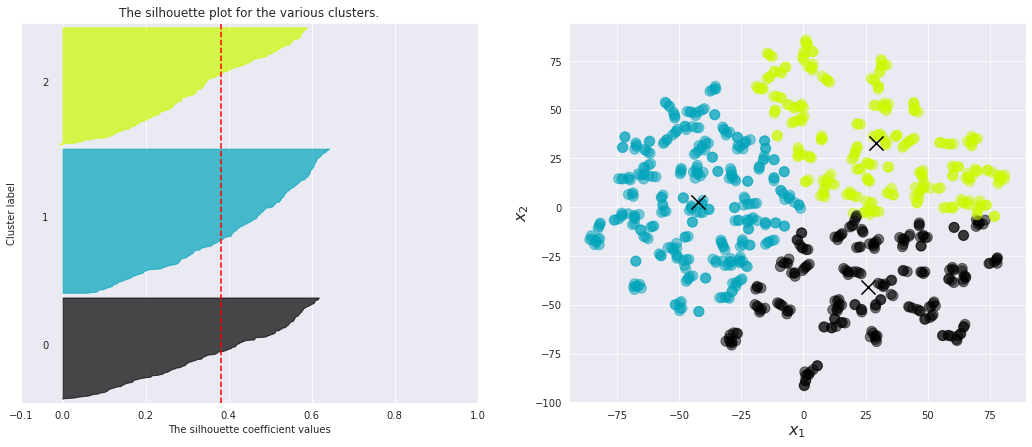

For n_clusters = 4, the average silhouette score is: 0.37168195843696594


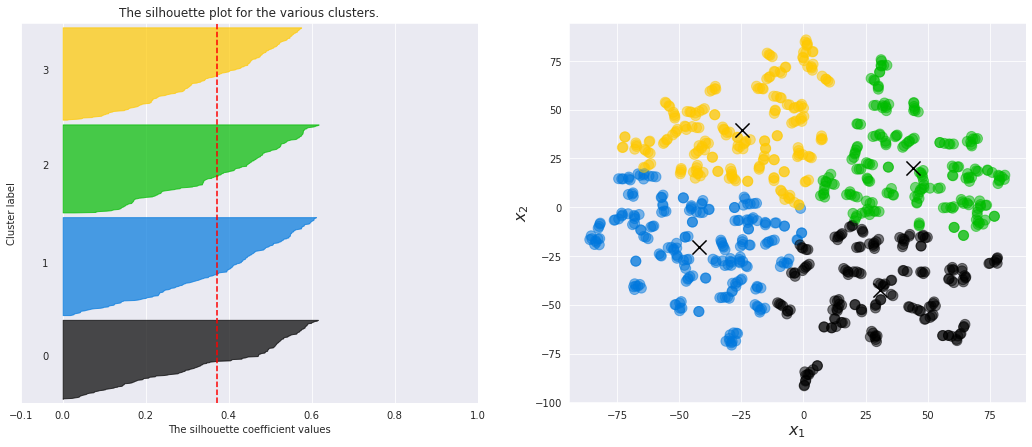

In [154]:
range_n_clusters = [2, 3, 4]

for k in range_n_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(X1_norm_reduced)
    
    # Calculate silhouette score
    silhouette_avg = silhouette_score(X1_norm_reduced, cluster_labels)
    print(f"For n_clusters = {k}, the average silhouette score is: {silhouette_avg}")
    plot_silhouette(X1_norm_reduced,k,kmeans.labels_,kmeans.cluster_centers_)


As it can be observed, none of the obtained silhouette coefficients can be considered good, since they do not even reach 0.5. Despite this, the best result obtained is for k=2, with a silhouette of 0.382.

We will now perform the same approach but using the data without dimensionality reduction.

For n_clusters = 2, the average silhouette score is: 0.2209220876202231


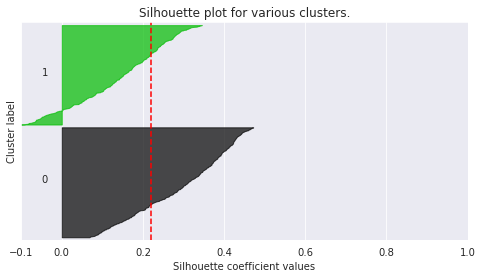

For n_clusters = 3, the average silhouette score is: 0.1676973469052012


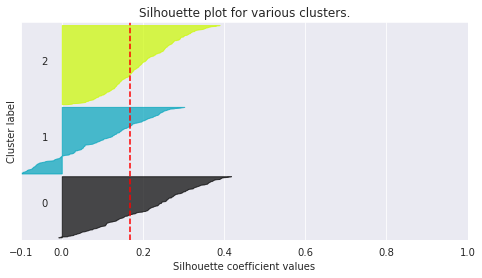

For n_clusters = 4, the average silhouette score is: 0.14988971104776191


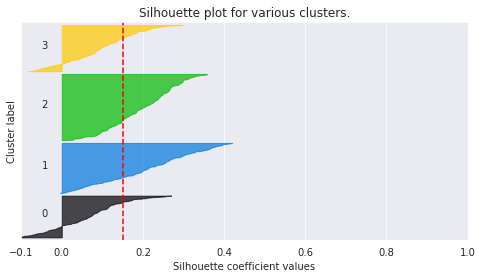

In [153]:
range_n_clusters = [2, 3, 4]

for n_clusters in range_n_clusters:
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X1_norm)

    silhouette_avg = silhouette_score(X1_norm, cluster_labels)
    print(f"For n_clusters = {n_clusters}, the average silhouette score is: {silhouette_avg}")

    sample_silhouette_values = silhouette_samples(X1_norm, cluster_labels)

    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(8, 4)

    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X1_norm) + (n_clusters + 1) * 10])

    y_lower = 10

    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = plt.cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10

    ax1.set_title("Silhouette plot for various clusters.")
    ax1.set_xlabel("Silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.show()


When using data without dimensionality reduction, the results are even worse, being the best one a silhouette of 0.22, for k=2. The best number of clusters is also 2, like with dimensionality reduction, but this time with lower certainty. This means that the algorithm is defining the corresponding cluster with barely any certainty, since the silhouette is too close to 0.


In general, such a low silhouette score in K-means clustering suggests that the clusters have a very small degree of separation, and the overall cohesion within clusters and separation between clusters is not pronounced. 

## Agglomerative hierarchical clustering

Data preprocessing: Hierarchical clustering algorithms, such as agglomerative hierarchical clustering, are less sensitive to differences in scale among features compared to some other clustering algorithms, like k-means. However, for visuallization purposes it is better to standardize the data. We will also evaluate the effect of reducing dimensionalization.


Agglomerative Hierarchical Clustering is a type of hierarchical clustering algorithm used for grouping similar objects into clusters in a tree-like structure. It starts with each data point as its own cluster and with each iteration it merges the closest clusters based on a chosen linkage criterion until all points belong to a single cluster. 

There are different linkage critera:
*    Single Linkage:
        Minimum distance between any two points in the clusters.

*    Complete Linkage:
        Maximum distance between any two points in the clusters.

*    Average Linkage:
        Average distance between all pairs of points in the clusters.

*    Ward's Linkage:
        Minimizes the variance within each cluster.

We will compare each of these methods to find the one that most suits our dataset, and use it to find the optimal amount of clusters.  The types of linkage will be compared by means of the cophenetic correlation coefficient.

To represent visually the hierarchy of merged clusters dendrograms will be used.

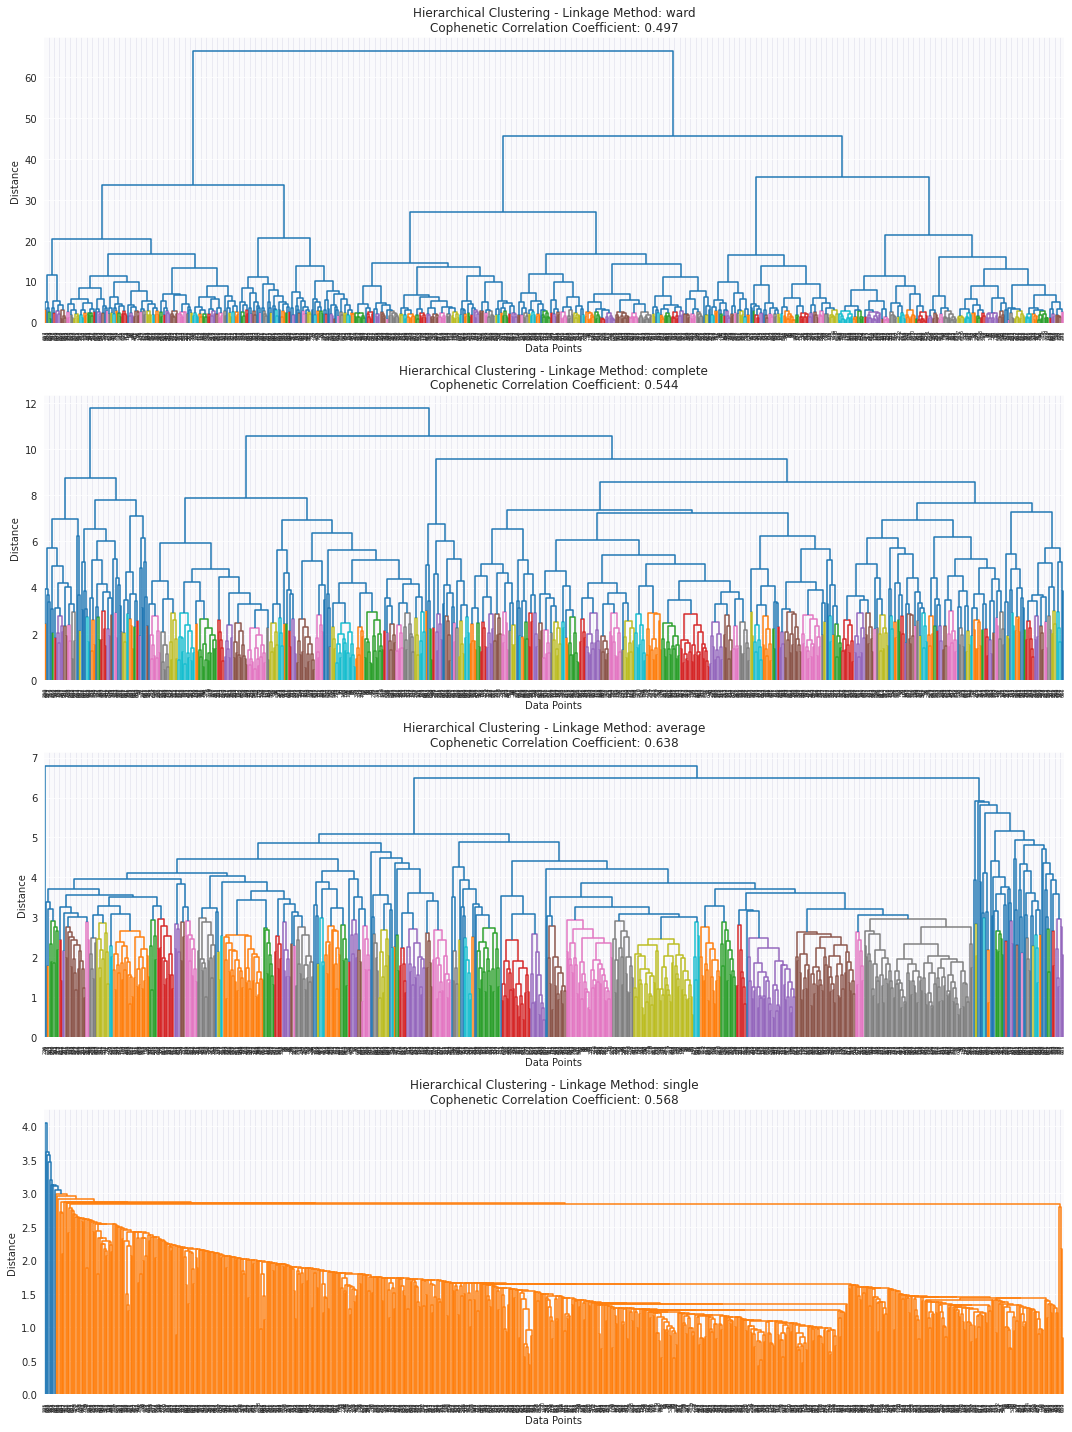

In [161]:
data = X1_norm

# Different linkage criteria
linkage_methods = ['ward', 'complete', 'average', 'single']

plt.figure(figsize=(15, 5 * len(linkage_methods)))

for i, method in enumerate(linkage_methods, 1):
    plt.subplot(len(linkage_methods), 1, i)
    
    # Perform hierarchical clustering
    Z = linkage(data, method=method)
    
    # Calculate cophenetic correlation coefficient
    c, coph_dists = cophenet(Z, pdist(data))
    
    # Plot dendrogram
    #dendrogram(Z, labels=np.arange(1, 11))
    dendrogram(Z, color_threshold=3)
    
    plt.title(f'Hierarchical Clustering - Linkage Method: {method}\nCophenetic Correlation Coefficient: {c:.3f}')
    plt.xlabel('Data Points')
    plt.ylabel('Distance')

plt.tight_layout()
plt.show()


Let's analyze the results obtained one by one:
* Ward Linkage: this type of linkage minimizes the variance within each cluster. As we can observe from the drendrogram, it tends to produce compact, spherical clusters. It results in well-balanced and evenly sized clusters.

* Complete Linkage: this kind of likage uses the maximum pairwise distance between points in different clusters as the linkage criterion. Looking at the dendrogram appearance, it results in elongated clusters as it merges clusters that have a single pair of points with a large distance.

* Average Linkage: this linkage uses the average pairwise distance between points in different clusters as the linkage criterion. The dredrogram produces more balanced clusters compared to complete linkage. It is also less sensitive to outliers.

* Single Linkage: it uses the minimum pairwise distance between points in different clusters as the linkage criterion. It is sensitive to outliers. The drendrogram results in many close clusterings.

A higher cophenetic correlation coefficient indicates better preservation of pairwise distances.
From the drendrogram and the cophenetic correlation coefficient it can be seen that the average linkage provides the best clustering method, so it is the one we will use from now on to obtain the optimal number of clusters. We will perform silhouette analysis, as in the Kmeans section, to compare each value of k and find the optimal.
Before doing this, we could reason by observing the heights at which the dendrogram's structure changes abruptly, that the number of clusters could be 2, or at least a small number close to it.


#### Preprocessing.
Standardizing the features ensures that all features contribute equally to the clustering process.
On the other hand, the hierarchical structure in agglomerative hierarchical clustering is built based on pairwise distances between data points. Dimensionality reduction can alter the pairwise distances, potentially changing the hierarchical relationships between clusters. For this reason, we consider best not to apply dimensionality reduction. Still, we will print both options.

In [162]:

range_n_clusters = [2, 3, 4]

for n_clusters in range_n_clusters:
    # Initialize AgglomerativeClustering with n_clusters and average linkage
    clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage="average")
    cluster_labels = clustering.fit_predict(X1_norm_reduced)

    # Calculate silhouette score
    silhouette_avg = silhouette_score(X1_norm_reduced, cluster_labels)
    print(f"For n_clusters = {n_clusters}, the average silhouette score is: {silhouette_avg}")



For n_clusters = 2, the average silhouette score is: 0.3735599219799042
For n_clusters = 3, the average silhouette score is: 0.34112241864204407
For n_clusters = 4, the average silhouette score is: 0.3850232660770416


With dimensionality reduction the silhouette scores are very low still, being the best one k=4. This result is not being good and it does not match either with that obtained in K-means.

In [163]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, silhouette_samples

range_n_clusters = [2, 3, 4]

for n_clusters in range_n_clusters:
    # Initialize AgglomerativeClustering with n_clusters and average linkage
    clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage="average")
    cluster_labels = clustering.fit_predict(X1_norm)

    # Calculate silhouette score
    silhouette_avg = silhouette_score(X1_norm, cluster_labels)
    print(f"For n_clusters = {n_clusters}, the average silhouette score is: {silhouette_avg}")



For n_clusters = 2, the average silhouette score is: 0.27723801360954387
For n_clusters = 3, the average silhouette score is: 0.2523550691986419
For n_clusters = 4, the average silhouette score is: 0.22779439473162422


Without dimensionality reduction, there are worse results. The best silhouette is obtained for 2 clusters, which matches the results obtained with kmeans but not those obtained with hierarchical clustering with dimensionality reduction.

We will plot below the dendrogram without the dimensionality reduction and with the dotted line representing the distance that would have to be defined to obtain two clusters.

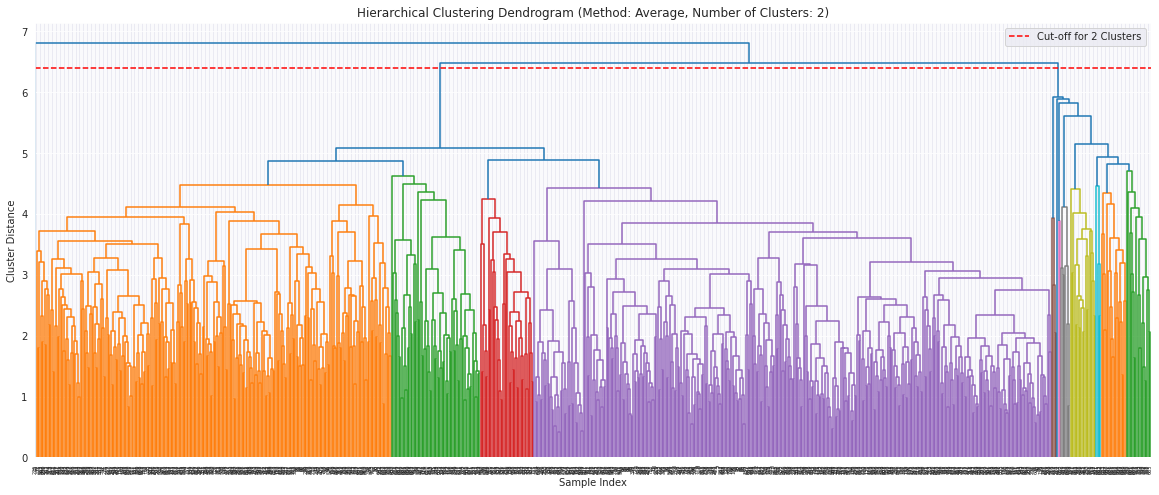

In [189]:
Z = linkage(X1_norm, 'average')
dendrogram(Z)
plt.xlabel('Sample Index')
plt.ylabel('Cluster Distance')
plt.title('Hierarchical Clustering Dendrogram (Method: Average, Number of Clusters: 2)')

# Highlight the cut-off for 2 clusters
plt.axhline(y=6.4, color='r', linestyle='--', label='Cut-off for 2 Clusters')

# Show legend
plt.legend()

# Show the plot
plt.show()



**Obtain the vector / patter of each group.** 

For k-means clustering, the vector refers to the centroids of a cluster, which is calculated as the mean of the feature values for all data points within that cluster. The process involves taking the average value for each feature separately. 

For hierarchical clustering with average linkage, the centroid at each step of the clustering process is computed as the average of the feature values of the merged clusters.

We will start by calculating the centroid vectors for the Kmeans with dimensionality reduction.

In [178]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(X1_norm_reduced)

centroids = kmeans.cluster_centers_
centroids


array([[ 28.582283,  18.710493],
       [-32.888016, -21.058851]], dtype=float32)

Now for hierarchical clustering, with normalized and dimensionality reduced data:

In [188]:
Z = linkage(X1_norm, 'average')

cut_off_threshold = 6.5
labels = fcluster(Z, cut_off_threshold, criterion='distance')

# Calculate centroids for each cluster
centroids = np.array([np.mean(X1_norm_reduced[labels == cluster], axis=0) for cluster in np.unique(labels)])
centroids

array([[  0.5659873,   0.5705008],
       [-48.589436 , -19.307838 ]], dtype=float32)

The centroids variables contains the centroid vectors for each cluster. Each row corresponds to a cluster, and each column corresponds to a feature. 